# CDF Analysis

This notebook aims to generate a higher-order CDF from the individual distributions of each recorded sale.

In [10]:
"""define some useful constants & imports"""

import csv

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import uniform, norm

from stats.utils import PlotSale

DELTA_1_HOUR = 24
DELTA_1_MINUTE = DELTA_1_HOUR * 60
DELTA_1_SECOND = DELTA_1_MINUTE * 60


In [11]:
"""load data from csv - we assume this lives in sales.csv in the current dir"""

plot_sales = []
all_plot_sales = []

with open('sales.csv', newline='') as f:
    reader = csv.DictReader(f)
    for row in reader:
        ps = PlotSale.parse_obj(row)
        all_plot_sales.append(ps)
        if not ps.is_relo:
            plot_sales.append(ps)


# filter by precision
def sales_filter(sales, min_precision, max_sale_price=5000000, max_mean_sale_time=24, min_mean_sale_time=0):
    return [
        s for s in sales
        # sale must be at least this precise
        if s.precision <= min_precision
           # filters out med/large relo edge cases
           and s.known_price <= max_sale_price
           # filters out plots not immediately bought off timer and plots that are likely misreported relos
           and max_mean_sale_time >= ((s.open_dur_min + s.open_dur_max) / 2) >= min_mean_sale_time
    ]


sales_2 = sales_filter(plot_sales, min_precision=2, min_mean_sale_time=0)  # set mean_min_sale_time=5 to remove <5h
sales_4 = sales_filter(plot_sales, min_precision=4)
sales_6 = sales_filter(plot_sales, min_precision=6)

print(f"data loaded: {len(plot_sales)=}, {len(sales_2)=}, {len(sales_4)=}, {len(sales_6)=}")

data loaded: len(plot_sales)=18395, len(sales_2)=1862, len(sales_4)=3678, len(sales_6)=5117


Given the imprecision in the underlying data used to generate the sale dataset, each plot's *sale duration*
(i.e. the duration of time during which the house was on the market) is represented as a continuous uniform
distribution between the smallest such duration and the largest such duration.

An example of this distribution and its PDF and CDF is shown below.

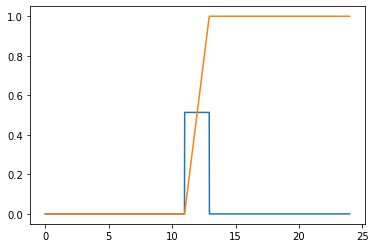

In [12]:
"""plot a sample sale dist, let's say the first one"""

x = np.linspace(0, 24, num=DELTA_1_MINUTE)
fig, ax = plt.subplots()

plot: PlotSale = sales_2[0]
plot_dist = uniform(plot.open_dur_min, plot.open_dur_max - plot.open_dur_min)

pdf = plot_dist.pdf(x)
cdf = plot_dist.cdf(x)

ax.plot(x, pdf, x, cdf)

Now, we plot *every* sale in this manner (or, at least, the first 1000):

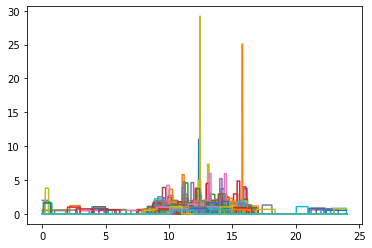

In [13]:
"""oh boy this is going to get pretty messy"""

x = np.linspace(0, 24, num=DELTA_1_MINUTE)
fig, ax = plt.subplots()
sales_under_analysis = sales_2

for plot in sales_under_analysis[:1000]:
    plot_dist = uniform(plot.open_dur_min, plot.open_dur_max - plot.open_dur_min)
    pdf = plot_dist.pdf(x)
    # cdf = plot_dist.cdf(x)  # the cdf isn't much use in this jumble, it just looks like a line @ y=1

    ax.plot(x, pdf)

What does this tell us (aside from that I need more RAM)?

By itself, this is pretty much just a mess of lines and colors, but we can start to see some semblance of a distribution
emerging from the chaos. Let's sum up all the PDFs and CDFs to produce a higher-order distribution:

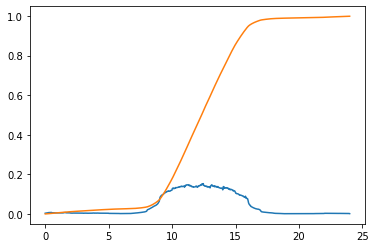

In [14]:
"""thats some nice ram you have there... would be a shame if something happened to it"""

x = np.linspace(0, 24, num=DELTA_1_MINUTE)
fig, ax = plt.subplots()


def do_higher_order_dist(sales_under_analysis):
    ho_pdf = np.zeros_like(x)
    ho_cdf = np.zeros_like(x)

    for plot in sales_under_analysis:
        plot_dist = uniform(plot.open_dur_min, plot.open_dur_max - plot.open_dur_min)
        pdf = plot_dist.pdf(x)
        cdf = plot_dist.cdf(x)
        ho_pdf += pdf
        ho_cdf += cdf

    # normalize
    ho_pdf /= len(sales_under_analysis)
    ho_cdf /= len(sales_under_analysis)
    return ho_pdf, ho_cdf


dist_under_analysis = ho_pdf_2, ho_cdf_2 = do_higher_order_dist(sales_2)
ax.plot(x, ho_pdf_2, x, ho_cdf_2)

This looks much more uniform than the previously-theorized normal distribution. For comparison, we plot this
distribution alongside the previously hypothesized normal distribution, the best-fit uniform distribution, and the
best-fit normal distribution:

The edges of the PDF smooth out when analyzing the 4 or 6 hour precision sales. This makes the observed PDF fit the
normal distribution better! **To look at the data for 4/6 hours, change the argument of `do_higher_order_dist(sales_2)`
to `sales_4` or `sales_6`.** Additionally, to analyze data for other precisions, you may supply
`sales_filter(plot_sales, min_precision=X)` as the argument.

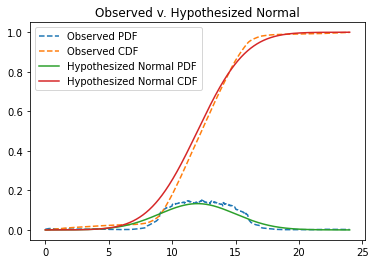

In [15]:
x = np.linspace(0, 24, num=DELTA_1_MINUTE)
fig, ax = plt.subplots()
hyp_norm = norm(12, 3)  # hypothesized normal: mean=12, stddev=3

def cmp_hyp_norm(ho_pdf, ho_cdf):
    ax.plot(x, ho_pdf, label="Observed PDF", linestyle='--')
    ax.plot(x, ho_cdf, label="Observed CDF", linestyle='--')
    ax.plot(x, hyp_norm.pdf(x), label="Hypothesized Normal PDF")
    ax.plot(x, hyp_norm.cdf(x), label="Hypothesized Normal CDF")
    ax.legend()
    ax.set_title("Observed v. Hypothesized Normal")

cmp_hyp_norm(*dist_under_analysis)

Best fit uniform: U(8.514322263751355, 16.159358445944573)


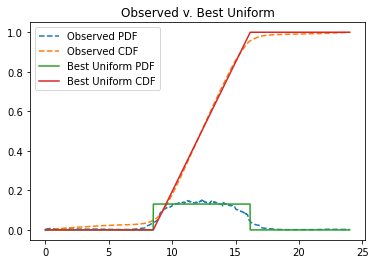

In [16]:
from scipy.optimize import curve_fit

x = np.linspace(0, 24, num=DELTA_1_MINUTE)
fig, ax = plt.subplots()

def fit_uniform(ho_pdf, ho_cdf):
    # fit uniform cdf to higher order cdf
    popt, pcov = curve_fit(lambda x, a, b: uniform(a, b).cdf(x), x, ho_cdf, p0=(8.5, 7.5))
    print(f"Best fit uniform: U({popt[0]}, {popt[0] + popt[1]})")
    best_uniform = uniform(*popt)

    ax.plot(x, ho_pdf, label="Observed PDF", linestyle='--')
    ax.plot(x, ho_cdf, label="Observed CDF", linestyle='--')
    ax.plot(x, best_uniform.pdf(x), label="Best Uniform PDF")
    ax.plot(x, best_uniform.cdf(x), label="Best Uniform CDF")
    ax.legend()
    ax.set_title("Observed v. Best Uniform")

fit_uniform(*dist_under_analysis)

Similarly, let's find the best-fit uniform distribution:

Best fit normal: N(12.328391752598412, 2.5095611936075457)


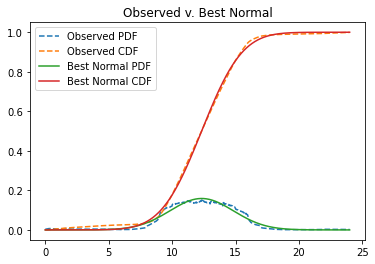

In [17]:
x = np.linspace(0, 24, num=DELTA_1_MINUTE)
fig, ax = plt.subplots()

def fit_normal(ho_pdf, ho_cdf):
    # fit normal cdf to higher order cdf
    popt, pcov = curve_fit(lambda x, a, b: norm(a, b).cdf(x), x, ho_cdf, p0=(12, 3))
    print(f"Best fit normal: N({popt[0]}, {popt[1]})")
    best_norm = norm(*popt)

    ax.plot(x, ho_pdf, label="Observed PDF", linestyle='--')
    ax.plot(x, ho_cdf, label="Observed CDF", linestyle='--')
    ax.plot(x, best_norm.pdf(x), label="Best Normal PDF")
    ax.plot(x, best_norm.cdf(x), label="Best Normal CDF")
    ax.legend()
    ax.set_title("Observed v. Best Normal")

fit_normal(*dist_under_analysis)

It looks like it could be either, really, but going off of numbers alone, I'm more inclined to believe it's implemented
as a uniform distribution of ``U(9, 16)``, as that's the easiest to implement in game code.

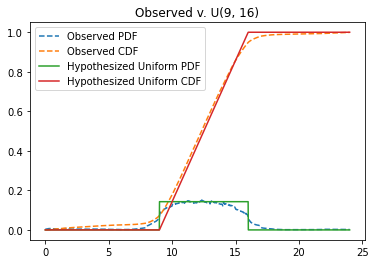

In [18]:
x = np.linspace(0, 24, num=DELTA_1_MINUTE)
fig, ax = plt.subplots()
hyp_unif = uniform(9, 7)

def cmp_hyp_unif(ho_pdf, ho_cdf):
    ax.plot(x, ho_pdf, label="Observed PDF", linestyle='--')
    ax.plot(x, ho_cdf, label="Observed CDF", linestyle='--')
    ax.plot(x, hyp_unif.pdf(x), label="Hypothesized Uniform PDF")
    ax.plot(x, hyp_unif.cdf(x), label="Hypothesized Uniform CDF")
    ax.legend()
    ax.set_title("Observed v. U(9, 16)")

cmp_hyp_unif(*dist_under_analysis)